In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "MNIST"
model_name = "flow_vcr_mse"
ood = "0"

In [3]:
# Parameters
ood = 0


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                             | 0/60000 [00:00<?, ?it/s]

 10%|██████▌                                                        | 6203/60000 [00:00<00:00, 62017.79it/s]

 21%|█████████████▎                                                | 12851/60000 [00:00<00:00, 64638.91it/s]

 33%|████████████████████▎                                         | 19606/60000 [00:00<00:00, 65966.88it/s]

 44%|███████████████████████████                                   | 26203/60000 [00:00<00:00, 63582.87it/s]

 55%|██████████████████████████████████                            | 32985/60000 [00:00<00:00, 65071.44it/s]

 66%|████████████████████████████████████████▉                     | 39637/60000 [00:00<00:00, 65552.81it/s]

 77%|███████████████████████████████████████████████▊              | 46304/60000 [00:00<00:00, 65912.82it/s]

 88%|██████████████████████████████████████████████████████▋       | 52983/60000 [00:00<00:00, 66189.61it/s]

 99%|█████████████████████████████████████████████████████████████▋| 59647/60000 [00:00<00:00, 66326.67it/s]

100%|██████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 65354.73it/s]

  0%|                                                                             | 0/10000 [00:00<?, ?it/s]

 66%|█████████████████████████████████████████▋                     | 6619/10000 [00:00<00:00, 66186.28it/s]

100%|██████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 65606.42it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
model_ids = {
    "0:1:2:3:4": '59ftut3f',
    "5:6:7:8:9": "lz2g3fq1",
    "0": "cpnxtpv2",
    "1": "c6sohudf",
    "2": "5qeniujh",
    "3": "cto6ipr0",
}
ood_str = ":".join(map(str, config.ood))
model_id = model_ids[ood_str]
print(ood_str, model_id)

0 cpnxtpv2


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from models.common import edl_probs
from tqdm import tqdm

trn_targets = []
val_targets = []
ind_targets = []
if ood_str:
    ood_targets = []

trn_u_norms = []
val_u_norms = []
ind_u_norms = []
if ood_str:
    ood_u_norms = []
rnd_u_norms = []

trn_v_norms = []
val_v_norms = []
ind_v_norms = []
if ood_str:
    ood_v_norms = []
rnd_v_norms = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    trn_u_norms.extend(u_norm.detach().cpu().numpy())
    trn_v_norms.extend(v_norm.detach().cpu().numpy())
    trn_targets.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    val_u_norms.extend(u_norm.detach().cpu().numpy())
    val_v_norms.extend(v_norm.detach().cpu().numpy())
    val_targets.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ind_u_norms.extend(u_norm.detach().cpu().numpy())
    ind_v_norms.extend(v_norm.detach().cpu().numpy())
    ind_targets.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        v, z, x_m, u_norm, v_norm, logits = model(x)
        ood_u_norms.extend(u_norm.detach().cpu().numpy())
        ood_v_norms.extend(v_norm.detach().cpu().numpy())
        ood_targets.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    rnd_u_norms.extend(u_norm.detach().cpu().numpy())
    rnd_v_norms.extend(v_norm.detach().cpu().numpy())
print("test RnD - OK")

trn_targets = np.array(trn_targets).squeeze()
val_targets = np.array(val_targets).squeeze()
ind_targets = np.array(ind_targets).squeeze()
if ood_str:
    ood_targets = np.array(ood_targets).squeeze()

trn_u_norms = np.array(trn_u_norms).squeeze()
val_u_norms = np.array(val_u_norms).squeeze()
ind_u_norms = np.array(ind_u_norms).squeeze()
if ood_str:
    ood_u_norms = np.array(ood_u_norms).squeeze()
rnd_u_norms = np.array(rnd_u_norms).squeeze()

trn_v_norms = np.array(trn_v_norms).squeeze()
val_v_norms = np.array(val_v_norms).squeeze()
ind_v_norms = np.array(ind_v_norms).squeeze()
if ood_str:
    ood_v_norms = np.array(ood_v_norms).squeeze()
rnd_v_norms = np.array(rnd_v_norms).squeeze()

print(trn_u_norms.shape, trn_v_norms.shape)
print(val_u_norms.shape, val_v_norms.shape)
print(ind_u_norms.shape, ind_v_norms.shape)
if ood_str:
    print(ood_u_norms.shape, ood_v_norms.shape)
print(rnd_u_norms.shape, rnd_v_norms.shape)

  0%|                                                                               | 0/676 [00:00<?, ?it/s]

  0%|                                                                       | 1/676 [00:00<09:28,  1.19it/s]

  1%|▌                                                                      | 5/676 [00:00<01:42,  6.55it/s]

  1%|▉                                                                      | 9/676 [00:01<00:56, 11.77it/s]

  2%|█▎                                                                    | 13/676 [00:01<00:40, 16.50it/s]

  3%|█▊                                                                    | 17/676 [00:01<00:31, 20.67it/s]

  3%|██▏                                                                   | 21/676 [00:01<00:27, 24.10it/s]

  4%|██▌                                                                   | 25/676 [00:01<00:24, 26.76it/s]

  4%|███                                                                   | 29/676 [00:01<00:22, 28.86it/s]

  5%|███▍                                                                  | 33/676 [00:01<00:21, 30.44it/s]

  5%|███▊                                                                  | 37/676 [00:01<00:20, 31.59it/s]

  6%|████▏                                                                 | 41/676 [00:02<00:19, 32.43it/s]

  7%|████▋                                                                 | 45/676 [00:02<00:19, 33.05it/s]

  7%|█████                                                                 | 49/676 [00:02<00:18, 33.44it/s]

  8%|█████▍                                                                | 53/676 [00:02<00:18, 33.78it/s]

  8%|█████▉                                                                | 57/676 [00:02<00:18, 33.94it/s]

  9%|██████▎                                                               | 61/676 [00:02<00:18, 34.16it/s]

 10%|██████▋                                                               | 65/676 [00:02<00:17, 34.28it/s]

 10%|███████▏                                                              | 69/676 [00:02<00:17, 34.33it/s]

 11%|███████▌                                                              | 73/676 [00:02<00:17, 34.38it/s]

 11%|███████▉                                                              | 77/676 [00:03<00:17, 34.42it/s]

 12%|████████▍                                                             | 81/676 [00:03<00:17, 34.40it/s]

 13%|████████▊                                                             | 85/676 [00:03<00:17, 34.44it/s]

 13%|█████████▏                                                            | 89/676 [00:03<00:17, 34.26it/s]

 14%|█████████▋                                                            | 93/676 [00:03<00:16, 34.32it/s]

 14%|██████████                                                            | 97/676 [00:03<00:16, 34.36it/s]

 15%|██████████▎                                                          | 101/676 [00:03<00:16, 34.37it/s]

 16%|██████████▋                                                          | 105/676 [00:03<00:16, 34.40it/s]

 16%|███████████▏                                                         | 109/676 [00:03<00:16, 34.15it/s]

 17%|███████████▌                                                         | 113/676 [00:04<00:16, 34.26it/s]

 17%|███████████▉                                                         | 117/676 [00:04<00:16, 34.30it/s]

 18%|████████████▎                                                        | 121/676 [00:04<00:16, 34.36it/s]

 18%|████████████▊                                                        | 125/676 [00:04<00:16, 34.39it/s]

 19%|█████████████▏                                                       | 129/676 [00:04<00:15, 34.44it/s]

 20%|█████████████▌                                                       | 133/676 [00:04<00:15, 34.40it/s]

 20%|█████████████▉                                                       | 137/676 [00:04<00:15, 34.37it/s]

 21%|██████████████▍                                                      | 141/676 [00:04<00:15, 34.35it/s]

 21%|██████████████▊                                                      | 145/676 [00:05<00:15, 34.41it/s]

 22%|███████████████▏                                                     | 149/676 [00:05<00:15, 34.33it/s]

 23%|███████████████▌                                                     | 153/676 [00:05<00:15, 34.38it/s]

 23%|████████████████                                                     | 157/676 [00:05<00:15, 34.32it/s]

 24%|████████████████▍                                                    | 161/676 [00:05<00:14, 34.35it/s]

 24%|████████████████▊                                                    | 165/676 [00:05<00:14, 34.37it/s]

 25%|█████████████████▎                                                   | 169/676 [00:05<00:14, 34.35it/s]

 26%|█████████████████▋                                                   | 173/676 [00:05<00:14, 34.39it/s]

 26%|██████████████████                                                   | 177/676 [00:05<00:14, 34.36it/s]

 27%|██████████████████▍                                                  | 181/676 [00:06<00:14, 34.33it/s]

 27%|██████████████████▉                                                  | 185/676 [00:06<00:14, 34.30it/s]

 28%|███████████████████▎                                                 | 189/676 [00:06<00:14, 34.22it/s]

 29%|███████████████████▋                                                 | 193/676 [00:06<00:14, 34.30it/s]

 29%|████████████████████                                                 | 197/676 [00:06<00:13, 34.33it/s]

 30%|████████████████████▌                                                | 201/676 [00:06<00:13, 34.33it/s]

 30%|████████████████████▉                                                | 205/676 [00:06<00:13, 34.31it/s]

 31%|█████████████████████▎                                               | 209/676 [00:06<00:13, 34.36it/s]

 32%|█████████████████████▋                                               | 213/676 [00:07<00:13, 34.38it/s]

 32%|██████████████████████▏                                              | 217/676 [00:07<00:13, 34.34it/s]

 33%|██████████████████████▌                                              | 221/676 [00:07<00:13, 34.26it/s]

 33%|██████████████████████▉                                              | 225/676 [00:07<00:13, 34.31it/s]

 34%|███████████████████████▎                                             | 229/676 [00:07<00:13, 34.35it/s]

 34%|███████████████████████▊                                             | 233/676 [00:07<00:12, 34.36it/s]

 35%|████████████████████████▏                                            | 237/676 [00:07<00:12, 34.32it/s]

 36%|████████████████████████▌                                            | 241/676 [00:07<00:12, 34.40it/s]

 36%|█████████████████████████                                            | 245/676 [00:07<00:12, 34.34it/s]

 37%|█████████████████████████▍                                           | 249/676 [00:08<00:12, 34.22it/s]

 37%|█████████████████████████▊                                           | 253/676 [00:08<00:12, 34.27it/s]

 38%|██████████████████████████▏                                          | 257/676 [00:08<00:12, 34.29it/s]

 39%|██████████████████████████▋                                          | 261/676 [00:08<00:12, 34.29it/s]

 39%|███████████████████████████                                          | 265/676 [00:08<00:11, 34.29it/s]

 40%|███████████████████████████▍                                         | 269/676 [00:08<00:11, 34.35it/s]

 40%|███████████████████████████▊                                         | 273/676 [00:08<00:11, 34.33it/s]

 41%|████████████████████████████▎                                        | 277/676 [00:08<00:11, 34.30it/s]

 42%|████████████████████████████▋                                        | 281/676 [00:09<00:11, 34.24it/s]

 42%|█████████████████████████████                                        | 285/676 [00:09<00:11, 34.29it/s]

 43%|█████████████████████████████▍                                       | 289/676 [00:09<00:11, 34.32it/s]

 43%|█████████████████████████████▉                                       | 293/676 [00:09<00:11, 34.25it/s]

 44%|██████████████████████████████▎                                      | 297/676 [00:09<00:11, 34.21it/s]

 45%|██████████████████████████████▋                                      | 301/676 [00:09<00:10, 34.31it/s]

 45%|███████████████████████████████▏                                     | 305/676 [00:09<00:10, 34.28it/s]

 46%|███████████████████████████████▌                                     | 309/676 [00:09<00:10, 34.25it/s]

 46%|███████████████████████████████▉                                     | 313/676 [00:09<00:10, 34.24it/s]

 47%|████████████████████████████████▎                                    | 317/676 [00:10<00:10, 34.07it/s]

 47%|████████████████████████████████▊                                    | 321/676 [00:10<00:10, 34.13it/s]

 48%|█████████████████████████████████▏                                   | 325/676 [00:10<00:10, 34.18it/s]

 49%|█████████████████████████████████▌                                   | 329/676 [00:10<00:10, 34.24it/s]

 49%|█████████████████████████████████▉                                   | 333/676 [00:10<00:10, 34.27it/s]

 50%|██████████████████████████████████▍                                  | 337/676 [00:10<00:09, 34.30it/s]

 50%|██████████████████████████████████▊                                  | 341/676 [00:10<00:09, 34.29it/s]

 51%|███████████████████████████████████▏                                 | 345/676 [00:10<00:09, 34.28it/s]

 52%|███████████████████████████████████▌                                 | 349/676 [00:10<00:09, 34.28it/s]

 52%|████████████████████████████████████                                 | 353/676 [00:11<00:09, 34.25it/s]

 53%|████████████████████████████████████▍                                | 357/676 [00:11<00:09, 34.24it/s]

 53%|████████████████████████████████████▊                                | 361/676 [00:11<00:09, 34.27it/s]

 54%|█████████████████████████████████████▎                               | 365/676 [00:11<00:09, 34.30it/s]

 55%|█████████████████████████████████████▋                               | 369/676 [00:11<00:08, 34.28it/s]

 55%|██████████████████████████████████████                               | 373/676 [00:11<00:08, 34.28it/s]

 56%|██████████████████████████████████████▍                              | 377/676 [00:11<00:08, 34.24it/s]

 56%|██████████████████████████████████████▉                              | 381/676 [00:11<00:08, 34.27it/s]

 57%|███████████████████████████████████████▎                             | 385/676 [00:12<00:08, 34.25it/s]

 58%|███████████████████████████████████████▋                             | 389/676 [00:12<00:08, 34.22it/s]

 58%|████████████████████████████████████████                             | 393/676 [00:12<00:08, 34.22it/s]

 59%|████████████████████████████████████████▌                            | 397/676 [00:12<00:08, 34.23it/s]

 59%|████████████████████████████████████████▉                            | 401/676 [00:12<00:08, 34.27it/s]

 60%|█████████████████████████████████████████▎                           | 405/676 [00:12<00:07, 34.22it/s]

 61%|█████████████████████████████████████████▋                           | 409/676 [00:12<00:07, 34.28it/s]

 61%|██████████████████████████████████████████▏                          | 413/676 [00:12<00:07, 34.29it/s]

 62%|██████████████████████████████████████████▌                          | 417/676 [00:12<00:07, 34.26it/s]

 62%|██████████████████████████████████████████▉                          | 421/676 [00:13<00:07, 34.13it/s]

 63%|███████████████████████████████████████████▍                         | 425/676 [00:13<00:07, 34.12it/s]

 63%|███████████████████████████████████████████▊                         | 429/676 [00:13<00:07, 34.21it/s]

 64%|████████████████████████████████████████████▏                        | 433/676 [00:13<00:07, 34.26it/s]

 65%|████████████████████████████████████████████▌                        | 437/676 [00:13<00:06, 34.27it/s]

 65%|█████████████████████████████████████████████                        | 441/676 [00:13<00:06, 34.24it/s]

 66%|█████████████████████████████████████████████▍                       | 445/676 [00:13<00:06, 34.21it/s]

 66%|█████████████████████████████████████████████▊                       | 449/676 [00:13<00:06, 34.23it/s]

 67%|██████████████████████████████████████████████▏                      | 453/676 [00:14<00:06, 34.17it/s]

 68%|██████████████████████████████████████████████▋                      | 457/676 [00:14<00:06, 34.28it/s]

 68%|███████████████████████████████████████████████                      | 461/676 [00:14<00:06, 34.33it/s]

 69%|███████████████████████████████████████████████▍                     | 465/676 [00:14<00:06, 34.29it/s]

 69%|███████████████████████████████████████████████▊                     | 469/676 [00:14<00:06, 34.30it/s]

 70%|████████████████████████████████████████████████▎                    | 473/676 [00:14<00:05, 34.29it/s]

 71%|████████████████████████████████████████████████▋                    | 477/676 [00:14<00:05, 34.26it/s]

 71%|█████████████████████████████████████████████████                    | 481/676 [00:14<00:05, 34.21it/s]

 72%|█████████████████████████████████████████████████▌                   | 485/676 [00:14<00:05, 34.23it/s]

 72%|█████████████████████████████████████████████████▉                   | 489/676 [00:15<00:05, 34.23it/s]

 73%|██████████████████████████████████████████████████▎                  | 493/676 [00:15<00:05, 34.23it/s]

 74%|██████████████████████████████████████████████████▋                  | 497/676 [00:15<00:05, 34.21it/s]

 74%|███████████████████████████████████████████████████▏                 | 501/676 [00:15<00:05, 34.21it/s]

 75%|███████████████████████████████████████████████████▌                 | 505/676 [00:15<00:05, 34.11it/s]

 75%|███████████████████████████████████████████████████▉                 | 509/676 [00:15<00:04, 34.10it/s]

 76%|████████████████████████████████████████████████████▎                | 513/676 [00:15<00:04, 34.10it/s]

 76%|████████████████████████████████████████████████████▊                | 517/676 [00:15<00:04, 34.15it/s]

 77%|█████████████████████████████████████████████████████▏               | 521/676 [00:16<00:04, 34.20it/s]

 78%|█████████████████████████████████████████████████████▌               | 525/676 [00:16<00:04, 34.04it/s]

 78%|█████████████████████████████████████████████████████▉               | 529/676 [00:16<00:04, 33.99it/s]

 79%|██████████████████████████████████████████████████████▍              | 533/676 [00:16<00:04, 34.09it/s]

 79%|██████████████████████████████████████████████████████▊              | 537/676 [00:16<00:04, 34.11it/s]

 80%|███████████████████████████████████████████████████████▏             | 541/676 [00:16<00:03, 34.11it/s]

 81%|███████████████████████████████████████████████████████▋             | 545/676 [00:16<00:03, 34.16it/s]

 81%|████████████████████████████████████████████████████████             | 549/676 [00:16<00:03, 34.17it/s]

 82%|████████████████████████████████████████████████████████▍            | 553/676 [00:16<00:03, 34.24it/s]

 82%|████████████████████████████████████████████████████████▊            | 557/676 [00:17<00:03, 34.22it/s]

 83%|█████████████████████████████████████████████████████████▎           | 561/676 [00:17<00:03, 34.24it/s]

 84%|█████████████████████████████████████████████████████████▋           | 565/676 [00:17<00:03, 34.25it/s]

 84%|██████████████████████████████████████████████████████████           | 569/676 [00:17<00:03, 34.19it/s]

 85%|██████████████████████████████████████████████████████████▍          | 573/676 [00:17<00:03, 34.25it/s]

 85%|██████████████████████████████████████████████████████████▉          | 577/676 [00:17<00:02, 34.25it/s]

 86%|███████████████████████████████████████████████████████████▎         | 581/676 [00:17<00:02, 34.27it/s]

 87%|███████████████████████████████████████████████████████████▋         | 585/676 [00:17<00:02, 34.26it/s]

 87%|████████████████████████████████████████████████████████████         | 589/676 [00:18<00:02, 34.25it/s]

 88%|████████████████████████████████████████████████████████████▌        | 593/676 [00:18<00:02, 34.26it/s]

 88%|████████████████████████████████████████████████████████████▉        | 597/676 [00:18<00:02, 34.28it/s]

 89%|█████████████████████████████████████████████████████████████▎       | 601/676 [00:18<00:02, 34.18it/s]

 89%|█████████████████████████████████████████████████████████████▊       | 605/676 [00:18<00:02, 34.20it/s]

 90%|██████████████████████████████████████████████████████████████▏      | 609/676 [00:18<00:01, 34.25it/s]

 91%|██████████████████████████████████████████████████████████████▌      | 613/676 [00:18<00:01, 34.20it/s]

 91%|██████████████████████████████████████████████████████████████▉      | 617/676 [00:18<00:01, 34.19it/s]

 92%|███████████████████████████████████████████████████████████████▍     | 621/676 [00:18<00:01, 34.18it/s]

 92%|███████████████████████████████████████████████████████████████▊     | 625/676 [00:19<00:01, 34.19it/s]

 93%|████████████████████████████████████████████████████████████████▏    | 629/676 [00:19<00:01, 34.19it/s]

 94%|████████████████████████████████████████████████████████████████▌    | 633/676 [00:19<00:01, 34.13it/s]

 94%|█████████████████████████████████████████████████████████████████    | 637/676 [00:19<00:01, 34.14it/s]

 95%|█████████████████████████████████████████████████████████████████▍   | 641/676 [00:19<00:01, 34.17it/s]

 95%|█████████████████████████████████████████████████████████████████▊   | 645/676 [00:19<00:00, 34.07it/s]

 96%|██████████████████████████████████████████████████████████████████▏  | 649/676 [00:19<00:00, 33.88it/s]

 97%|██████████████████████████████████████████████████████████████████▋  | 653/676 [00:19<00:00, 33.96it/s]

 97%|███████████████████████████████████████████████████████████████████  | 657/676 [00:19<00:00, 34.03it/s]

 98%|███████████████████████████████████████████████████████████████████▍ | 661/676 [00:20<00:00, 34.12it/s]

 98%|███████████████████████████████████████████████████████████████████▉ | 665/676 [00:20<00:00, 34.19it/s]

 99%|████████████████████████████████████████████████████████████████████▎| 669/676 [00:20<00:00, 34.25it/s]

100%|████████████████████████████████████████████████████████████████████▋| 673/676 [00:20<00:00, 35.08it/s]

100%|█████████████████████████████████████████████████████████████████████| 676/676 [00:20<00:00, 32.79it/s]

train - OK


  0%|                                                                               | 0/169 [00:00<?, ?it/s]

  1%|▍                                                                      | 1/169 [00:00<00:24,  6.82it/s]

  3%|██                                                                     | 5/169 [00:00<00:07, 20.89it/s]

  5%|███▊                                                                   | 9/169 [00:00<00:06, 26.49it/s]

  8%|█████▍                                                                | 13/169 [00:00<00:05, 29.35it/s]

 10%|███████                                                               | 17/169 [00:00<00:04, 31.01it/s]

 12%|████████▋                                                             | 21/169 [00:00<00:04, 31.94it/s]

 15%|██████████▎                                                           | 25/169 [00:00<00:04, 31.84it/s]

 17%|████████████                                                          | 29/169 [00:00<00:04, 32.49it/s]

 20%|█████████████▋                                                        | 33/169 [00:01<00:04, 32.96it/s]

 22%|███████████████▎                                                      | 37/169 [00:01<00:03, 33.31it/s]

 24%|████████████████▉                                                     | 41/169 [00:01<00:03, 33.56it/s]

 27%|██████████████████▋                                                   | 45/169 [00:01<00:03, 33.72it/s]

 29%|████████████████████▎                                                 | 49/169 [00:01<00:03, 33.82it/s]

 31%|█████████████████████▉                                                | 53/169 [00:01<00:03, 33.95it/s]

 34%|███████████████████████▌                                              | 57/169 [00:01<00:03, 33.99it/s]

 36%|█████████████████████████▎                                            | 61/169 [00:01<00:03, 33.99it/s]

 38%|██████████████████████████▉                                           | 65/169 [00:02<00:03, 34.01it/s]

 41%|████████████████████████████▌                                         | 69/169 [00:02<00:02, 34.01it/s]

 43%|██████████████████████████████▏                                       | 73/169 [00:02<00:02, 34.02it/s]

 46%|███████████████████████████████▉                                      | 77/169 [00:02<00:02, 34.05it/s]

 48%|█████████████████████████████████▌                                    | 81/169 [00:02<00:02, 34.03it/s]

 50%|███████████████████████████████████▏                                  | 85/169 [00:02<00:02, 34.00it/s]

 53%|████████████████████████████████████▊                                 | 89/169 [00:02<00:02, 34.03it/s]

 55%|██████████████████████████████████████▌                               | 93/169 [00:02<00:02, 33.84it/s]

 57%|████████████████████████████████████████▏                             | 97/169 [00:02<00:02, 33.89it/s]

 60%|█████████████████████████████████████████▏                           | 101/169 [00:03<00:02, 33.94it/s]

 62%|██████████████████████████████████████████▊                          | 105/169 [00:03<00:01, 34.02it/s]

 64%|████████████████████████████████████████████▌                        | 109/169 [00:03<00:01, 34.12it/s]

 67%|██████████████████████████████████████████████▏                      | 113/169 [00:03<00:01, 34.05it/s]

 69%|███████████████████████████████████████████████▊                     | 117/169 [00:03<00:01, 34.09it/s]

 72%|█████████████████████████████████████████████████▍                   | 121/169 [00:03<00:01, 34.05it/s]

 74%|███████████████████████████████████████████████████                  | 125/169 [00:03<00:01, 34.09it/s]

 76%|████████████████████████████████████████████████████▋                | 129/169 [00:03<00:01, 34.00it/s]

 79%|██████████████████████████████████████████████████████▎              | 133/169 [00:04<00:01, 34.09it/s]

 81%|███████████████████████████████████████████████████████▉             | 137/169 [00:04<00:00, 34.12it/s]

 83%|█████████████████████████████████████████████████████████▌           | 141/169 [00:04<00:00, 34.14it/s]

 86%|███████████████████████████████████████████████████████████▏         | 145/169 [00:04<00:00, 34.13it/s]

 88%|████████████████████████████████████████████████████████████▊        | 149/169 [00:04<00:00, 34.16it/s]

 91%|██████████████████████████████████████████████████████████████▍      | 153/169 [00:04<00:00, 34.20it/s]

 93%|████████████████████████████████████████████████████████████████     | 157/169 [00:04<00:00, 34.27it/s]

 95%|█████████████████████████████████████████████████████████████████▋   | 161/169 [00:04<00:00, 34.39it/s]

 98%|███████████████████████████████████████████████████████████████████▎ | 165/169 [00:04<00:00, 35.18it/s]

100%|█████████████████████████████████████████████████████████████████████| 169/169 [00:05<00:00, 35.78it/s]

100%|█████████████████████████████████████████████████████████████████████| 169/169 [00:05<00:00, 33.12it/s]

val - OK


  0%|                                                                               | 0/141 [00:00<?, ?it/s]

  1%|▌                                                                      | 1/141 [00:00<00:20,  6.70it/s]

  4%|██▌                                                                    | 5/141 [00:00<00:06, 20.83it/s]

  6%|████▌                                                                  | 9/141 [00:00<00:04, 26.45it/s]

  9%|██████▍                                                               | 13/141 [00:00<00:04, 29.38it/s]

 12%|████████▍                                                             | 17/141 [00:00<00:04, 30.92it/s]

 15%|██████████▍                                                           | 21/141 [00:00<00:03, 32.01it/s]

 18%|████████████▍                                                         | 25/141 [00:00<00:03, 32.59it/s]

 21%|██████████████▍                                                       | 29/141 [00:00<00:03, 32.96it/s]

 23%|████████████████▍                                                     | 33/141 [00:01<00:03, 33.25it/s]

 26%|██████████████████▎                                                   | 37/141 [00:01<00:03, 33.53it/s]

 29%|████████████████████▎                                                 | 41/141 [00:01<00:02, 33.63it/s]

 32%|██████████████████████▎                                               | 45/141 [00:01<00:02, 33.27it/s]

 35%|████████████████████████▎                                             | 49/141 [00:01<00:02, 33.43it/s]

 38%|██████████████████████████▎                                           | 53/141 [00:01<00:02, 33.66it/s]

 40%|████████████████████████████▎                                         | 57/141 [00:01<00:02, 33.77it/s]

 43%|██████████████████████████████▎                                       | 61/141 [00:01<00:02, 33.83it/s]

 46%|████████████████████████████████▎                                     | 65/141 [00:02<00:02, 33.87it/s]

 49%|██████████████████████████████████▎                                   | 69/141 [00:02<00:02, 33.92it/s]

 52%|████████████████████████████████████▏                                 | 73/141 [00:02<00:02, 33.91it/s]

 55%|██████████████████████████████████████▏                               | 77/141 [00:02<00:01, 34.02it/s]

 57%|████████████████████████████████████████▏                             | 81/141 [00:02<00:01, 34.06it/s]

 60%|██████████████████████████████████████████▏                           | 85/141 [00:02<00:01, 34.03it/s]

 63%|████████████████████████████████████████████▏                         | 89/141 [00:02<00:01, 34.02it/s]

 66%|██████████████████████████████████████████████▏                       | 93/141 [00:02<00:01, 34.08it/s]

 69%|████████████████████████████████████████████████▏                     | 97/141 [00:02<00:01, 34.07it/s]

 72%|█████████████████████████████████████████████████▍                   | 101/141 [00:03<00:01, 34.05it/s]

 74%|███████████████████████████████████████████████████▍                 | 105/141 [00:03<00:01, 34.05it/s]

 77%|█████████████████████████████████████████████████████▎               | 109/141 [00:03<00:00, 34.05it/s]

 80%|███████████████████████████████████████████████████████▎             | 113/141 [00:03<00:00, 34.07it/s]

 83%|█████████████████████████████████████████████████████████▎           | 117/141 [00:03<00:00, 34.05it/s]

 86%|███████████████████████████████████████████████████████████▏         | 121/141 [00:03<00:00, 34.03it/s]

 89%|█████████████████████████████████████████████████████████████▏       | 125/141 [00:03<00:00, 34.05it/s]

 91%|███████████████████████████████████████████████████████████████▏     | 129/141 [00:03<00:00, 34.08it/s]

 94%|█████████████████████████████████████████████████████████████████    | 133/141 [00:04<00:00, 34.08it/s]

 97%|███████████████████████████████████████████████████████████████████  | 137/141 [00:04<00:00, 34.84it/s]

100%|█████████████████████████████████████████████████████████████████████| 141/141 [00:04<00:00, 31.51it/s]

100%|█████████████████████████████████████████████████████████████████████| 141/141 [00:04<00:00, 32.52it/s]

test InD - OK


  0%|                                                                               | 0/108 [00:00<?, ?it/s]

  1%|▋                                                                      | 1/108 [00:00<00:15,  7.11it/s]

  5%|███▎                                                                   | 5/108 [00:00<00:04, 21.46it/s]

  8%|█████▉                                                                 | 9/108 [00:00<00:03, 27.00it/s]

 12%|████████▍                                                             | 13/108 [00:00<00:03, 29.70it/s]

 16%|███████████                                                           | 17/108 [00:00<00:02, 31.30it/s]

 19%|█████████████▌                                                        | 21/108 [00:00<00:02, 32.29it/s]

 23%|████████████████▏                                                     | 25/108 [00:00<00:02, 32.63it/s]

 27%|██████████████████▊                                                   | 29/108 [00:00<00:02, 33.12it/s]

 31%|█████████████████████▍                                                | 33/108 [00:01<00:02, 33.44it/s]

 34%|███████████████████████▉                                              | 37/108 [00:01<00:02, 33.68it/s]

 38%|██████████████████████████▌                                           | 41/108 [00:01<00:01, 33.71it/s]

 42%|█████████████████████████████▏                                        | 45/108 [00:01<00:01, 33.85it/s]

 45%|███████████████████████████████▊                                      | 49/108 [00:01<00:01, 33.77it/s]

 49%|██████████████████████████████████▎                                   | 53/108 [00:01<00:01, 33.83it/s]

 53%|████████████████████████████████████▉                                 | 57/108 [00:01<00:01, 33.76it/s]

 56%|███████████████████████████████████████▌                              | 61/108 [00:01<00:01, 33.82it/s]

 60%|██████████████████████████████████████████▏                           | 65/108 [00:02<00:01, 33.91it/s]

 64%|████████████████████████████████████████████▋                         | 69/108 [00:02<00:01, 34.04it/s]

 68%|███████████████████████████████████████████████▎                      | 73/108 [00:02<00:01, 34.00it/s]

 71%|█████████████████████████████████████████████████▉                    | 77/108 [00:02<00:00, 34.04it/s]

 75%|████████████████████████████████████████████████████▌                 | 81/108 [00:02<00:00, 34.06it/s]

 79%|███████████████████████████████████████████████████████               | 85/108 [00:02<00:00, 34.00it/s]

 82%|█████████████████████████████████████████████████████████▋            | 89/108 [00:02<00:00, 34.16it/s]

 86%|████████████████████████████████████████████████████████████▎         | 93/108 [00:02<00:00, 34.16it/s]

 90%|██████████████████████████████████████████████████████████████▊       | 97/108 [00:02<00:00, 34.12it/s]

 94%|████████████████████████████████████████████████████████████████▌    | 101/108 [00:03<00:00, 34.29it/s]

 97%|███████████████████████████████████████████████████████████████████  | 105/108 [00:03<00:00, 35.11it/s]

100%|█████████████████████████████████████████████████████████████████████| 108/108 [00:03<00:00, 32.45it/s]

test OoD - OK


  0%|                                                                               | 0/100 [00:00<?, ?it/s]

  4%|██▊                                                                    | 4/100 [00:00<00:02, 32.40it/s]

  8%|█████▋                                                                 | 8/100 [00:00<00:02, 35.94it/s]

 12%|████████▍                                                             | 12/100 [00:00<00:02, 37.28it/s]

 16%|███████████▏                                                          | 16/100 [00:00<00:02, 37.97it/s]

 20%|██████████████                                                        | 20/100 [00:00<00:02, 38.18it/s]

 24%|████████████████▊                                                     | 24/100 [00:00<00:01, 38.45it/s]

 28%|███████████████████▌                                                  | 28/100 [00:00<00:01, 38.65it/s]

 32%|██████████████████████▍                                               | 32/100 [00:00<00:01, 38.77it/s]

 36%|█████████████████████████▏                                            | 36/100 [00:00<00:01, 38.83it/s]

 40%|████████████████████████████                                          | 40/100 [00:01<00:01, 38.87it/s]

 44%|██████████████████████████████▊                                       | 44/100 [00:01<00:01, 38.76it/s]

 48%|█████████████████████████████████▌                                    | 48/100 [00:01<00:01, 38.83it/s]

 52%|████████████████████████████████████▍                                 | 52/100 [00:01<00:01, 38.85it/s]

 56%|███████████████████████████████████████▏                              | 56/100 [00:01<00:01, 38.74it/s]

 60%|██████████████████████████████████████████                            | 60/100 [00:01<00:01, 38.51it/s]

 64%|████████████████████████████████████████████▊                         | 64/100 [00:01<00:00, 38.62it/s]

 68%|███████████████████████████████████████████████▌                      | 68/100 [00:01<00:00, 38.54it/s]

 72%|██████████████████████████████████████████████████▍                   | 72/100 [00:01<00:00, 38.59it/s]

 76%|█████████████████████████████████████████████████████▏                | 76/100 [00:01<00:00, 38.71it/s]

 80%|████████████████████████████████████████████████████████              | 80/100 [00:02<00:00, 38.78it/s]

 84%|██████████████████████████████████████████████████████████▊           | 84/100 [00:02<00:00, 38.74it/s]

 88%|█████████████████████████████████████████████████████████████▌        | 88/100 [00:02<00:00, 38.82it/s]

 92%|████████████████████████████████████████████████████████████████▍     | 92/100 [00:02<00:00, 38.42it/s]

 96%|███████████████████████████████████████████████████████████████████▏  | 96/100 [00:02<00:00, 38.57it/s]

100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.65it/s]

100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.43it/s]

test RnD - OK
(43261,) (43261,)
(10816,) (10816,)
(9020,) (9020,)
(6903,) (6903,)
(6400,) (6400,)


In [11]:
trn_u_norms_scaled = np.tanh(trn_u_norms)
val_u_norms_scaled = np.tanh(val_u_norms)
ind_u_norms_scaled = np.tanh(ind_u_norms)
if ood_str:
    ood_u_norms_scaled = np.tanh(ood_u_norms)
rnd_u_norms_scaled = np.tanh(rnd_u_norms)

trn_v_norms_scaled = np.tanh(trn_v_norms)
val_v_norms_scaled = np.tanh(val_v_norms)
ind_v_norms_scaled = np.tanh(ind_v_norms)
if ood_str:
    ood_v_norms_scaled = np.tanh(ood_v_norms)
rnd_v_norms_scaled = np.tanh(rnd_v_norms)

print(trn_u_norms.mean(), trn_u_norms.std())
print(val_u_norms.mean(), val_u_norms.std())
print(ind_u_norms.mean(), ind_u_norms.std())
if ood_str:
    print(ood_u_norms.mean(), ood_u_norms.std())
print(rnd_u_norms.mean(), rnd_u_norms.std())

print(trn_v_norms.mean(), trn_v_norms.std())
print(val_v_norms.mean(), val_v_norms.std())
print(ind_v_norms.mean(), ind_v_norms.std())
if ood_str:
    print(ood_v_norms.mean(), ood_v_norms.std())
print(rnd_v_norms.mean(), rnd_v_norms.std())

8.039458 0.629385
8.020612 0.61921525
8.064067 0.62589544
8.849243 0.65039796
18.288042 1.0425389
17.33887 0.018393476
17.338913 0.01857352
17.338755 0.018865254
17.335571 0.022322105
34.355537 0.7716336


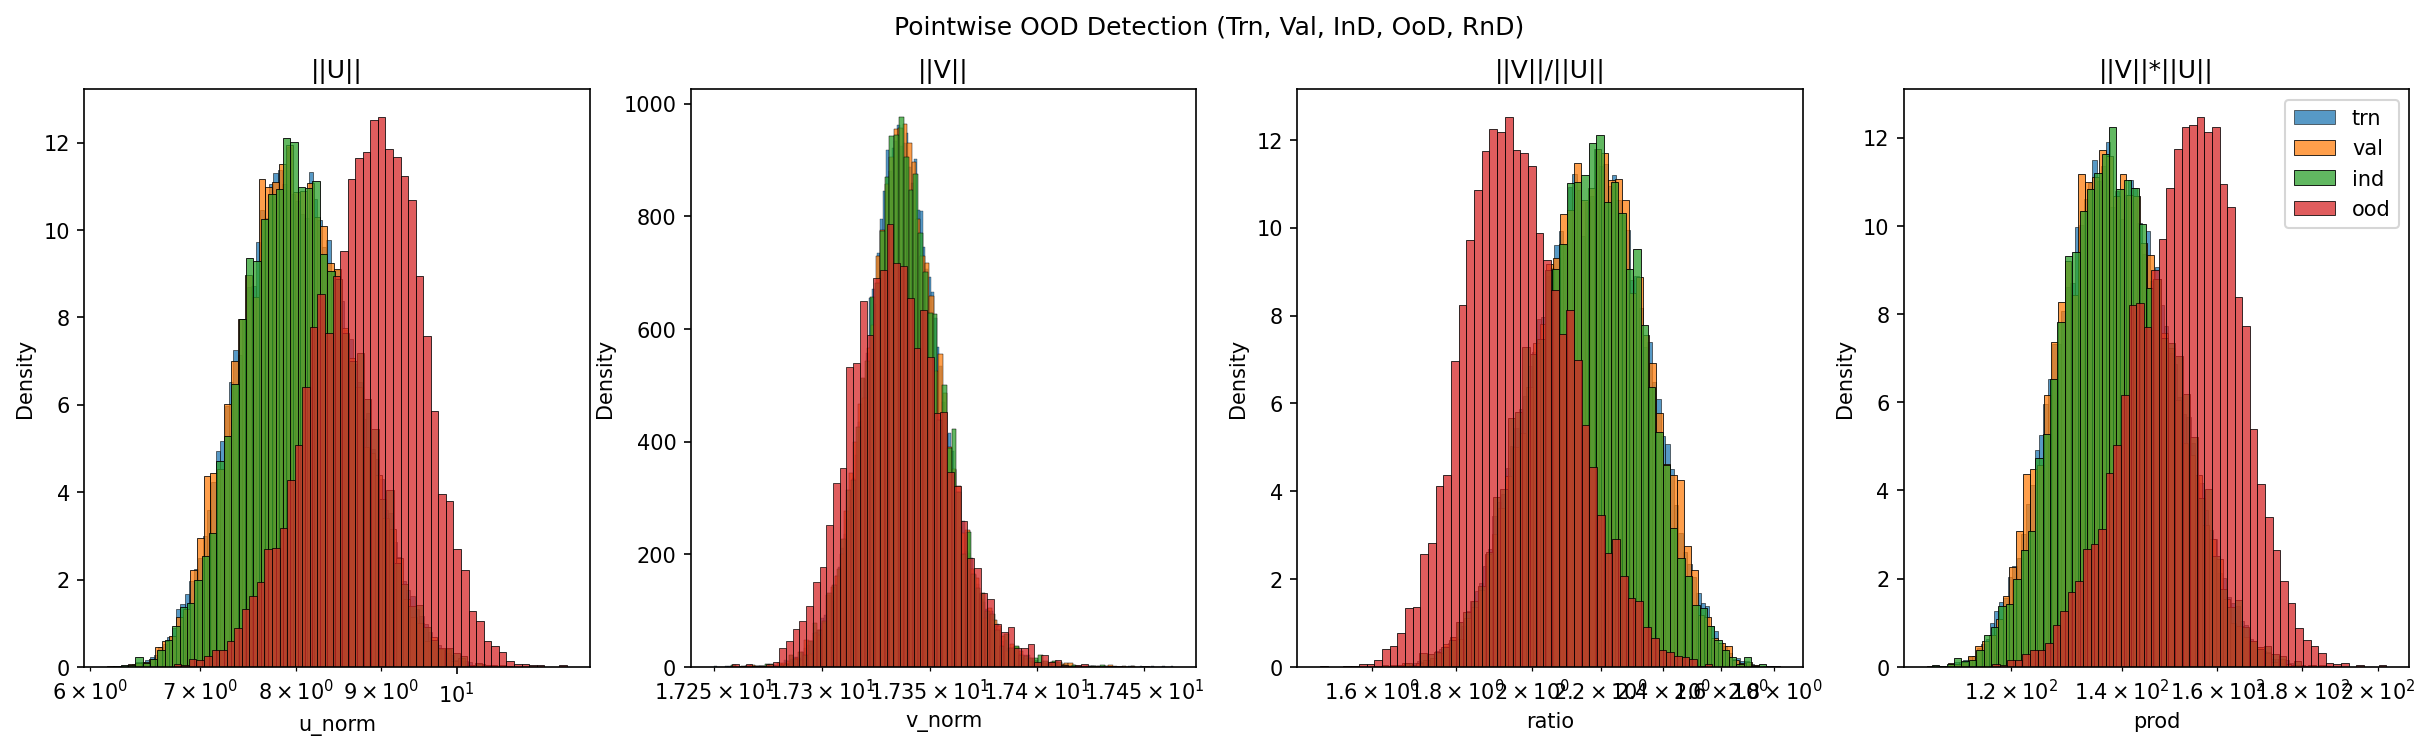

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_trn = pd.DataFrame(dict(u_norm=trn_u_norms, v_norm=trn_v_norms, ratio=trn_v_norms/trn_u_norms, prod=trn_v_norms*trn_u_norms, target=trn_targets))
data_val = pd.DataFrame(dict(u_norm=val_u_norms, v_norm=val_v_norms, ratio=val_v_norms/val_u_norms, prod=val_v_norms*val_u_norms, target=val_targets))
data_ind = pd.DataFrame(dict(u_norm=ind_u_norms, v_norm=ind_v_norms, ratio=ind_v_norms/ind_u_norms, prod=ind_v_norms*ind_u_norms, target=ind_targets))
if ood_str:
    data_ood = pd.DataFrame(dict(u_norm=ood_u_norms, v_norm=ood_v_norms, ratio=ood_v_norms/ood_u_norms, prod=ood_v_norms*ood_u_norms, target=ood_targets))
data_rnd = pd.DataFrame(dict(u_norm=rnd_u_norms, v_norm=rnd_v_norms, ratio=rnd_v_norms/rnd_u_norms, prod=rnd_v_norms*rnd_u_norms))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle("Pointwise OOD Detection (Trn, Val, InD, OoD, RnD)")

sns.histplot(data=data_trn, x="u_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax1)
sns.histplot(data=data_val, x="u_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax1)
sns.histplot(data=data_ind, x="u_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax1)
if ood_str:
    sns.histplot(data=data_ood, x="u_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax1)
# sns.histplot(data=data_rnd, x="u_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax1)

sns.histplot(data=data_trn, x="v_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax2)
sns.histplot(data=data_val, x="v_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax2)
sns.histplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax2)
if ood_str:
    sns.histplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax2)
# sns.histplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax2)

sns.histplot(data=data_trn, x="ratio", log_scale=True, fill=True, label='trn', stat='density', ax=ax3)
sns.histplot(data=data_val, x="ratio", log_scale=True, fill=True, label='val', stat='density', ax=ax3)
sns.histplot(data=data_ind, x="ratio", log_scale=True, fill=True, label='ind', stat='density', ax=ax3)
if ood_str:
    sns.histplot(data=data_ood, x="ratio", log_scale=True, fill=True, label='ood', stat='density', ax=ax3)
# sns.histplot(data=data_rnd, x="ratio", log_scale=True, fill=True, label='rnd', stat='density', ax=ax3)

sns.histplot(data=data_trn, x="prod", log_scale=True, fill=True, label='trn', stat='density', ax=ax4)
sns.histplot(data=data_val, x="prod", log_scale=True, fill=True, label='val', stat='density', ax=ax4)
sns.histplot(data=data_ind, x="prod", log_scale=True, fill=True, label='ind', stat='density', ax=ax4)
if ood_str:
    sns.histplot(data=data_ood, x="prod", log_scale=True, fill=True, label='ood', stat='density', ax=ax4)
# sns.histplot(data=data_rnd, x="prod", log_scale=True, fill=True, label='rnd', stat='density', ax=ax4)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.legend()
plt.show()

In [13]:
from scipy import stats
print("Trn", trn_v_norms.min(), trn_v_norms.max(), trn_v_norms.ptp())
print("Val", val_v_norms.min(), val_v_norms.max(), val_v_norms.ptp())
print("Ind", ind_v_norms.min(), ind_v_norms.max(), ind_v_norms.ptp())
if ood_str:
    print("Ood", ood_v_norms.min(), ood_v_norms.max(), ood_v_norms.ptp())
print("Rnd", rnd_v_norms.min(), rnd_v_norms.max(), rnd_v_norms.ptp())

if ood_str:
    ks_ind_ood = stats.kstest(ind_v_norms, ood_v_norms)
    print(ks_ind_ood)

Trn 17.24991 17.463839 0.21392822
Val 17.262646 17.446 0.18335342
Ind 17.257868 17.431887 0.17401886
Ood 17.258389 17.452196 0.1938076
Rnd 31.457582 37.17531 5.7177258
KstestResult(statistic=0.10967033517674278, pvalue=2.1266618740802889e-41, statistic_location=17.325026, statistic_sign=-1)


[6 1 0 3 8 4 5 2 7 9]


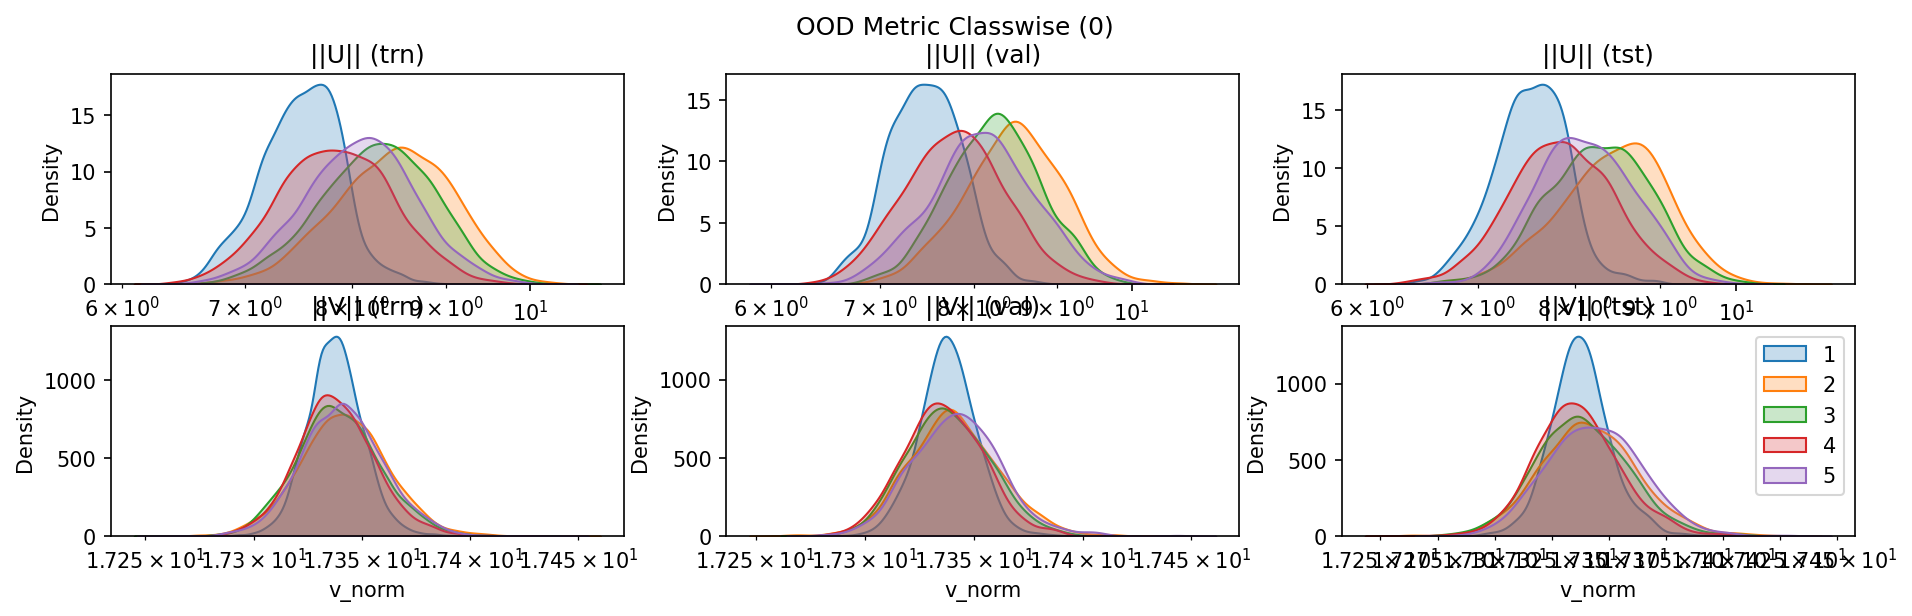

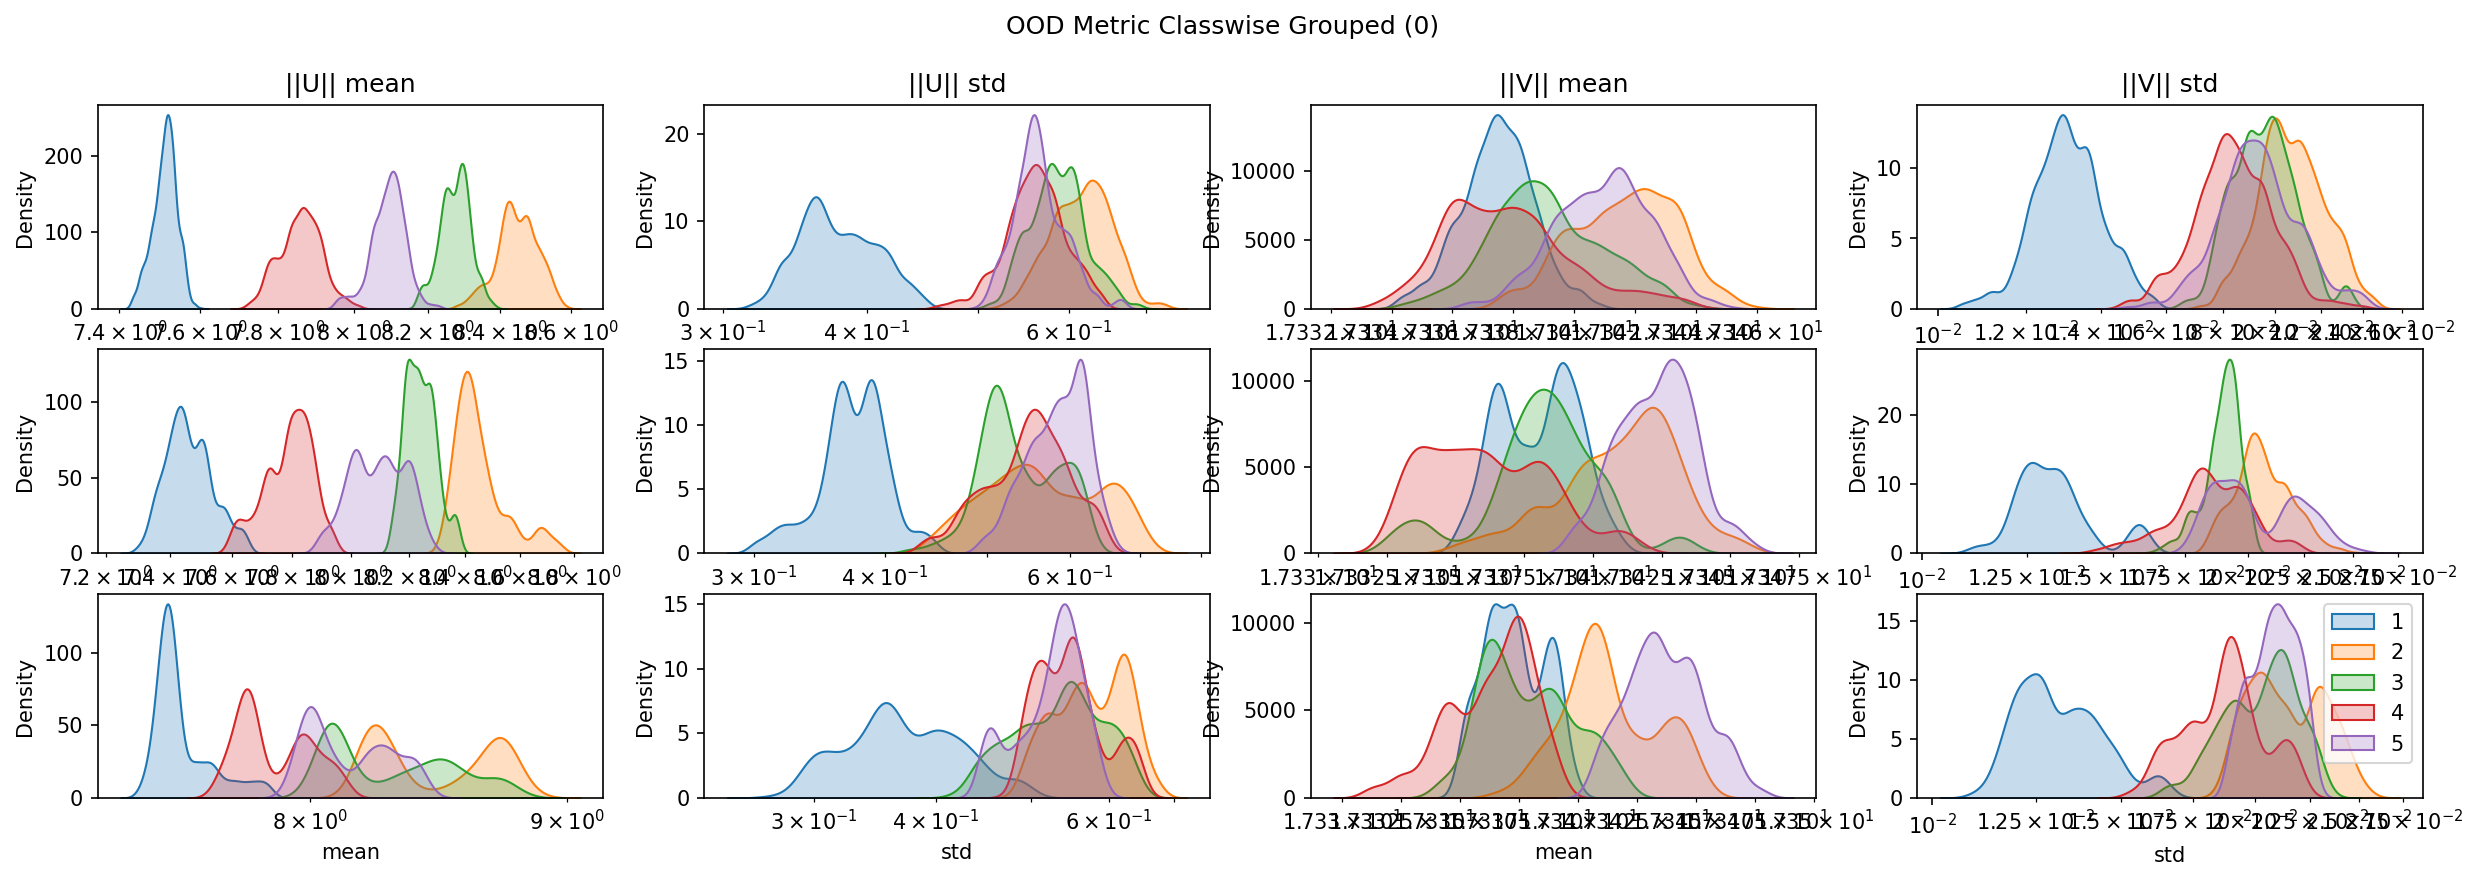

In [14]:
if ood_str:
    data_tst = pd.concat([data_ind, data_ood], axis=0)
else:
    data_tst = data_ind
print(data_tst['target'].unique())

N = 128

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(5):
    df_trn = data_trn[data_trn['target'] == i]
    df_val = data_val[data_val['target'] == i]
    df_tst = data_tst[data_tst['target'] == i]
    pointwise_trn[i] = df_trn.copy()
    pointwise_val[i] = df_val.copy()
    pointwise_tst[i] = df_tst.copy()
    groupwise_trn[i] = df_trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = df_val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = df_tst.rolling(N).agg(['mean', 'std']).dropna().copy()

# pointwise
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize = (15, 4))
fig.suptitle(f"OOD Metric Classwise ({ood_str})")

for i in range(5):
    df_trn = pointwise_trn[i]
    df_val = pointwise_val[i]
    df_tst = pointwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_val, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_tst, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax6)

ax1.title.set_text('||U|| (trn)')
ax2.title.set_text('||U|| (val)')
ax3.title.set_text('||U|| (tst)')
ax4.title.set_text('||V|| (trn)')
ax5.title.set_text('||V|| (val)')
ax6.title.set_text('||V|| (tst)')
plt.legend()
plt.show()
    
# groupwise
fig, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8], [ax9, axA, axB, axC]) = plt.subplots(3, 4, figsize = (20, 6))
fig.suptitle(f"OOD Metric Classwise Grouped ({ood_str})")

for i in range(5):
    df_trn = groupwise_trn[i]
    df_val = groupwise_val[i]
    df_tst = groupwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_trn.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_trn.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
        sns.kdeplot(data=df_val.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax6)
        sns.kdeplot(data=df_val.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax7)
        sns.kdeplot(data=df_val.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax8)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax9)
        sns.kdeplot(data=df_tst.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axA)
        sns.kdeplot(data=df_tst.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=axB)
        sns.kdeplot(data=df_tst.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axC)

ax1.title.set_text('||U|| mean')
ax2.title.set_text('||U|| std')
ax3.title.set_text('||V|| mean')
ax4.title.set_text('||V|| std')
plt.legend()
plt.show()

In [15]:
# save vector norms for hypothesis testing

base_path = Path(f"assets/embeddings/{config.dataset_name}_{config.model_name}_M{config.emb_dims}_{ood_str}")
base_path.mkdir(exist_ok=True)

for i in range(5):
    df_trn = pointwise_trn.get(i, None)
    df_val = pointwise_val.get(i, None)
    df_tst = pointwise_tst.get(i, None)
    if df_trn is not None and len(df_trn) > 0:
        np.save(base_path / f"train_{i}.npy", df_trn.v_norm.values)
    if df_val is not None and len(df_val) > 0:
        np.save(base_path / f"val_{i}.npy", df_val.v_norm.values)
    if df_tst is not None and len(df_tst) > 0:
        np.save(base_path / f"test_{i}.npy", df_tst.v_norm.values)